In [34]:
import csv
import os
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper,TURTLE,JSON
from pandas_ml import ConfusionMatrix
import pandas as pd
from sklearn import metrics

# DBpedia

In [35]:
POIS_PATH = os.path.normpath('5_0_doremus_dbpedia_artists.csv')

with open(POIS_PATH, 'r') as input_fp:

    reader = csv.reader(input_fp, )
    # skip header
    reader.next()
    matches = []
    for row in reader:
        match = dict()
        match['doremus_uri'] = row[0]
        match['dbpedia_uri'] = row[1]
        match['score'] = row[2]
        matches.append(match)

In [36]:
len(matches)

6026

In [37]:
offset = 0
finished = False
true_matches = []


sparql = SPARQLWrapper("http://data.doremus.org/sparql")
sparql.setReturnFormat(JSON)
sparql.setQuery(
"""
select $uri_doremus $dbpedia
where {
$uri_doremus ecrm:P131_is_identified_by $id_doremus.
$uri_doremus a ecrm:E21_Person.
$activity ecrm:P14_carried_out_by $uri_doremus.
$uri_doremus owl:sameAs $dbpedia.
FILTER (strStarts(str($dbpedia), 'http://dbpedia.org/resource/'))
} 
group by $uri_doremus    """ )

results = sparql.query().convert()
if len(results['results']['bindings']) > 0:
    for result in results['results']['bindings']:
        match = dict()
        match['doremus_uri'] = result['uri_doremus']['value']
        match['dbpedia_uri'] = result['dbpedia']['value']
        true_matches.append(match)          


In [38]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) >= threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    trues_disjoint = true[~true['doremus_uri'].isin(predicted['doremus_uri'])]
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['dbpedia_uri_x'])
    predict_label = list(join['dbpedia_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['dbpedia_uri_x'] == x['dbpedia_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint),len(trues_disjoint))



In [39]:
import numpy as np
stat_list = []
for threshold in np.arange(0,1.0,0.01):
    values = list(stats(matches,true_matches,threshold))
    values.append(threshold)
    stat_list.append(values)
stat_list = np.array(stat_list)

In [40]:
#accuracy,precision,recall,f1,intersection,predicted,true,threshold

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

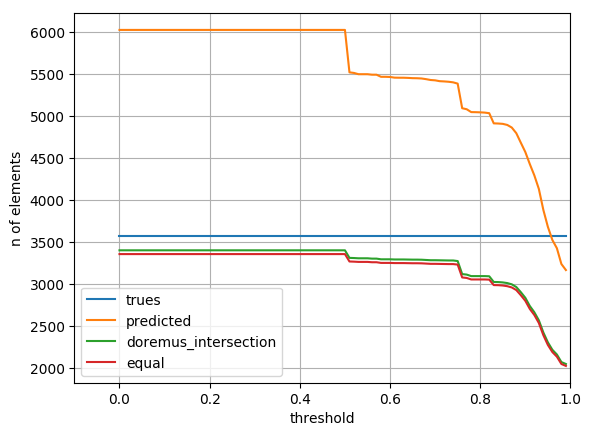

In [42]:
sns.reset_orig()

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,7])
#plt.plot(stat_list[:,-1],stat_list[:,8])
#plt.plot(stat_list[:,-1],stat_list[:,9])
#plt.plot(stat_list[:,-1],stat_list[:,10])

plt.grid()
plt.xlabel('threshold')
plt.ylabel('n of elements')
#plt.legend(['trues','predicted', 'doremus_intersection','equal','unequal','disjoint','true not in predicted'],loc="upper left")
plt.legend(['trues','predicted', 'doremus_intersection','equal'])
#plt.title('number of documents per category',fontsize=20)
plt.xlim([-0.1,1])
plt.savefig('count_artists_dbpedia.png', bbox_inches='tight')
plt.show()

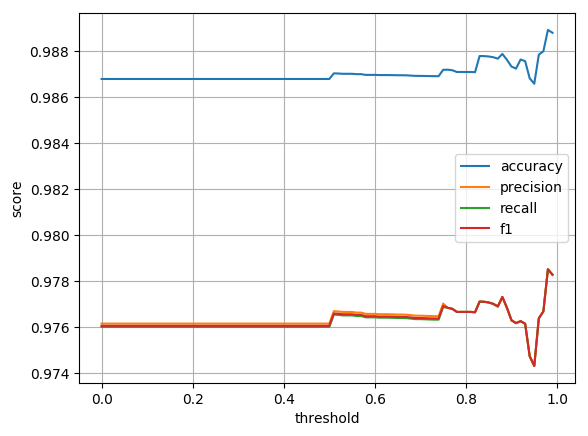

In [43]:
plt.plot(stat_list[:,-1],stat_list[:,0])
plt.plot(stat_list[:,-1],stat_list[:,1])
plt.plot(stat_list[:,-1],stat_list[:,2])
plt.plot(stat_list[:,-1],stat_list[:,3])
plt.grid()
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend(['accuracy', 'precision','recall','f1'])
plt.savefig('metrics_artists_dbpedia.png', bbox_inches='tight')
plt.show()

In [44]:
print('artists in trues and not in predicted: %d' % stat_list[:,10][-1])
print(stat_list[:,10][0])
print(stat_list[:,4][0])
print(stat_list[:,6][0])

artists in trues and not in predicted: 1523
170.0
3403.0
3573.0


## artists matched differently, choose the threshold

In [45]:
THRESHOLD = 0.5
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) >= THRESHOLD]
true = pd.DataFrame(true_matches)
join = true.merge(predicted, on='doremus_uri')
types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
for col in types[types=='unicode'].index:
    join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
join = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
print(len(join))

a= join[['dbpedia_uri_y','dbpedia_uri_x','doremus_uri','score']].values.tolist()
#for uri in a:
#    pprint(uri)
a= join[['dbpedia_uri_y','dbpedia_uri_x','doremus_uri','score']]
a = a.rename_axis({"dbpedia_uri_y": "our_match", "dbpedia_uri_x": "your_match"}, axis="columns")
a = a.sort_values('score',ascending=False)
a.to_csv('different_artists_'+ str(THRESHOLD)+'.csv',index=False)

45


## artists that are not linked with dbpedia, choose the threshold

In [46]:
THRESHOLD = 0.9
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) > THRESHOLD]
#predicted = predicted[predicted['score'].astype(float) <= 1.1]
true = pd.DataFrame(true_matches)

predicted = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score').values.tolist()
print(len(predicted))
#for uri in predicted:
#        pprint(uri)

1735


# wikidata

In [47]:
POIS_PATH = os.path.normpath('doremus_wikidata_artists.csv')

with open(POIS_PATH, 'r') as input_fp:

    reader = csv.reader(input_fp, )
    # skip header
    reader.next()
    matches = []
    for row in reader:
        match = dict()
        match['doremus_uri'] = row[0]
        match['wikidata_uri'] = row[1]
        match['score'] = float(row[5])/3
        matches.append(match)

In [48]:
len(matches)

2149

In [49]:
offset = 0
finished = False
true_matches = []


sparql = SPARQLWrapper("http://data.doremus.org/sparql")
sparql.setReturnFormat(JSON)
sparql.setQuery(
"""
select $uri_doremus $wikidata
where {
$uri_doremus ecrm:P131_is_identified_by $id_doremus.
$uri_doremus a ecrm:E21_Person.
$activity ecrm:P14_carried_out_by $uri_doremus.
$uri_doremus owl:sameAs $wikidata.
FILTER (strStarts(str($wikidata), 'http://www.wikidata.org/entity/'))
} 
group by $uri_doremus    """ )

results = sparql.query().convert()
if len(results['results']['bindings']) > 0:
    for result in results['results']['bindings']:
        match = dict()
        match['doremus_uri'] = result['uri_doremus']['value']
        match['wikidata_uri'] = result['wikidata']['value']
        true_matches.append(match)          


In [50]:
len(true_matches)

3952

In [51]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['dbpedia_uri_x'])
    predict_label = list(join['dbpedia_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['dbpedia_uri_x'] == x['dbpedia_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [52]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['wikidata_uri_x'])
    predict_label = list(join['wikidata_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['wikidata_uri_x'] == x['wikidata_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['wikidata_uri_x'] != x['wikidata_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [53]:
import numpy as np
stat_list = []
for threshold in np.arange(0,1.0,0.01):
    values = list(stats(matches,true_matches,threshold))
    values.append(threshold)
    stat_list.append(values)
stat_list = np.array(stat_list)

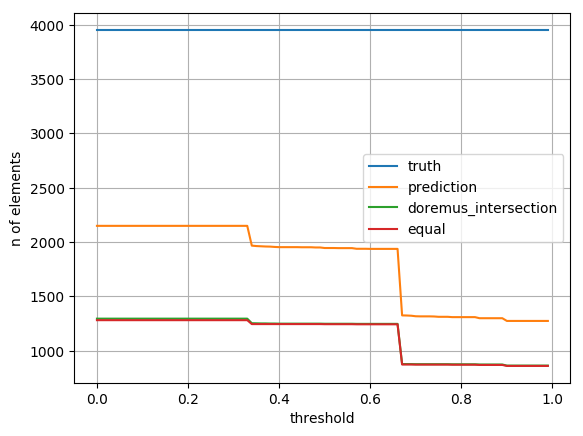

In [54]:
import seaborn as sns
sns.reset_orig()

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,7])

plt.grid()
plt.xlabel('threshold')
plt.ylabel('n of elements')
plt.legend(['truth','prediction', 'doremus_intersection','equal'])
plt.savefig('count_artists_wiki.png', bbox_inches='tight')
plt.show()

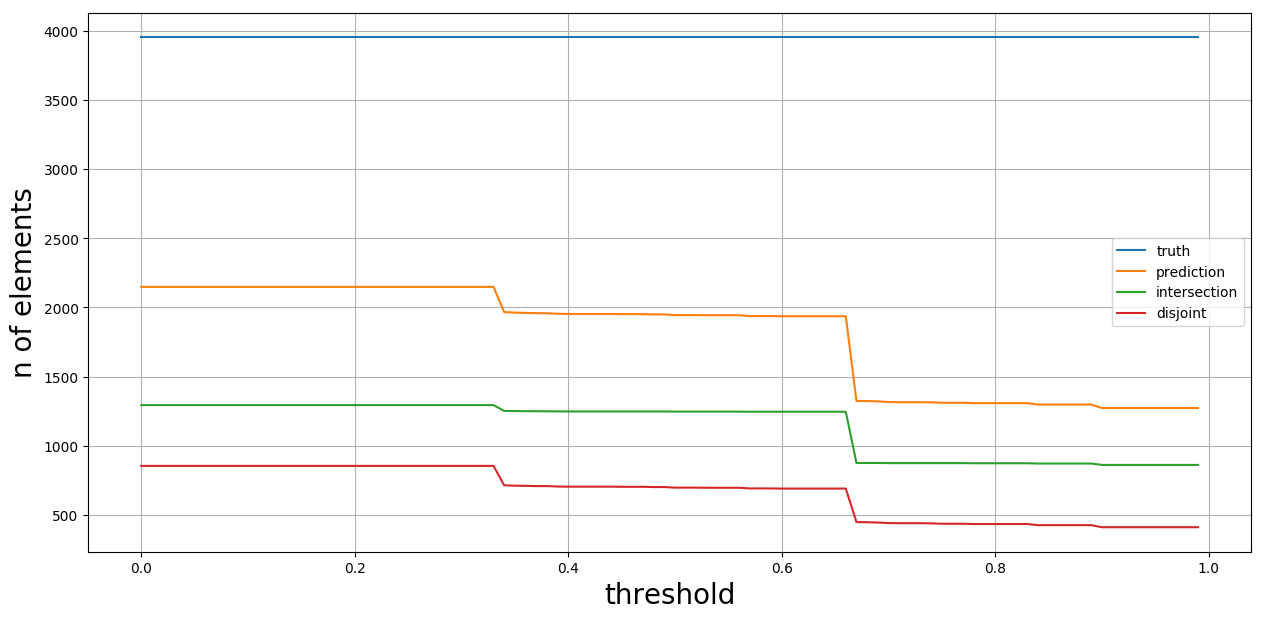

In [55]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,9])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['truth','prediction', 'intersection','disjoint'])
plt.savefig('count_artists_wiki_2.png', bbox_inches='tight')
plt.show()

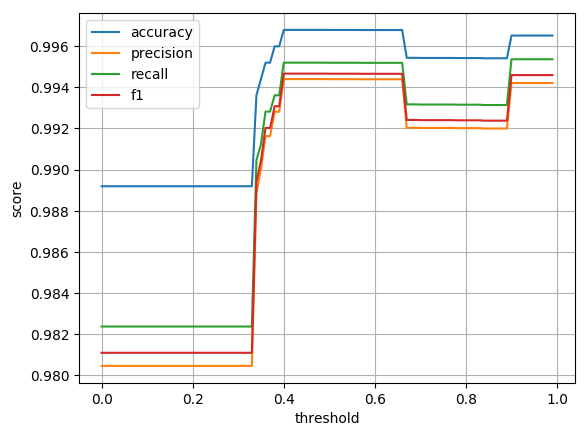

In [56]:
plt.plot(stat_list[:,-1],stat_list[:,0])
plt.plot(stat_list[:,-1],stat_list[:,1])
plt.plot(stat_list[:,-1],stat_list[:,2])
plt.plot(stat_list[:,-1],stat_list[:,3])
plt.grid()
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend(['accuracy', 'precision','recall','f1'])
plt.savefig('metrics_artists_wiki.png', bbox_inches='tight')
plt.show()

### Artists found that are not in ISNI

In [57]:
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) >= 1.0]
true = pd.DataFrame(true_matches)

predicted = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score').values.tolist()
print(len(predicted))
for uri in predicted:
        pprint(uri)

413
['http://data.doremus.org/artist/009540ee-244b-3332-9c2f-2d6e09603677',
 1.0,
 'http://www.wikidata.org/entity/Q5547245']
['http://data.doremus.org/artist/a27fc786-1c36-3a70-8e04-649237ed05b6',
 1.0,
 'http://www.wikidata.org/entity/Q1231115']
['http://data.doremus.org/artist/a27b1b3b-d37d-3f04-a3a2-a62cccfca190',
 1.0,
 'http://www.wikidata.org/entity/Q1687860']
['http://data.doremus.org/artist/a0d750ec-1d52-378a-8864-c1e499fa8667',
 1.0,
 'http://www.wikidata.org/entity/Q966778']
['http://data.doremus.org/artist/a0c496af-0c8d-30ed-9858-3e495b4923ad',
 1.0,
 'http://www.wikidata.org/entity/Q710733']
['http://data.doremus.org/artist/a06fb3a5-2ee7-39fd-93c8-d3cc757cde77',
 1.0,
 'http://www.wikidata.org/entity/Q46096']
['http://data.doremus.org/artist/9dd438f3-fdc9-355b-893e-e7bb9ab147d9',
 1.0,
 'http://www.wikidata.org/entity/Q1290316']
['http://data.doremus.org/artist/9dbaadc5-e795-3306-982c-8b2bd5187340',
 1.0,
 'http://www.wikidata.org/entity/Q48173']
['http://data.doremus.org/